# 自然语言处理（NLP）基础概念7：word2vec负采样（negtive sample）及skip-gram模型的python实现

本文章是斯坦福大学cs224n课程：[深度学习与自然语言处理课程](http://web.stanford.edu/class/cs224n/)的学习笔记！

直入正题，今天我们要做的是实现word2vec的核心概念skip-gram模型。
具体来说包括计算代价、计算梯度、负采样及skip-gram模型的python实现。

## 1. 准备工作

首先，我们需要加载必要的库和函数。
第一步，先加载必要的库：

In [1]:
import numpy as np 
import random

第二步，准备需要的函数，这里我们主要需要三个帮助函数。
- softmax函数，用于计算softmax。- 
- sigmoid函数，用于计算sigmoid。
- gradcheck_naive函数，梯度检查器，用于检查我们的梯度计算是否正确。

为了专注于构建word2vec的基本框架，这里的三个帮助函数我们不做说明，仅给出代码及使用方法。

下面是第一个函数softmax()

In [5]:
def softmax(x):
    """
    Compute the softmax function for each row of the input x.
    """
    orig_shape = x.shape

    if len(x.shape) > 1:
        tmp = np.max(x,axis=1)
        x-=tmp.reshape((x.shape[0],1))# here we use Numpy broadcasting

        x = np.exp(x)
        tmp = np.sum(x, axis = 1)
        x /= tmp.reshape((x.shape[0], 1))# here we use Numpy broadcasting

    else:
        # Vector 
        tmp = np.max(x)
        x -= tmp
        x = np.exp(x)
        tmp = np.sum(x)
        x /= tmp
    return x

此函数将输入x的行代入softmax公式进行计算，并输出转换后的x。
softmax公式如下：
$$softmax(x) = \frac {e^{x}}{\sum _j e^{x_j}}$$
读者可以看专栏的文章[自然语言处理（NLP）基础概念2：Softmax介绍及其python实现](http://link.zhihu.com/?target=http%3A//%2522%25E8%2587%25AA%25E7%2584%25B6%25E8%25AF%25AD%25E8%25A8%2580%25E5%25A4%2584%25E7%2590%2586%25EF%25BC%2588nlp%25EF%25BC%2589%25E5%259F%25BA%25E7%25A1%2580%25E6%25A6%2582%25E5%25BF%25B52%25EF%25BC%259Asoftmax%25E4%25BB%258B%25E7%25BB%258D%25E5%258F%258A%25E5%2585%25B6python%25E5%25AE%259E%25E7%258E%25B0%2522/)进一步了解softmax。

下面是第二个帮助函数sigmoid。

In [6]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    """
    s = 1./(1.+np.exp(-x))
    return s

sigmoid函数比较简单，根据公式输入实数x，输出sigmoid值s。
sigmoid公式如下：
$$\sigma(x) = \frac{1}{1+e^{-x}}$$

下面是最后一个帮助函数gradcheck_naive：

In [8]:
def gradcheck_naive(f, x):
    """ Gradient check for a function f.
    """
    rndstate = random.getstate()
    random.setstate(rndstate)
    fx, grad = f(x) # Evaluate function value at original point
    h = 1e-4        

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        random.setstate(rndstate)
        tmp1 = np.copy(x) 
        tmp1[ix] = tmp1[ix] + h
        f1, _ = f(tmp1)
        
        random.setstate(rndstate)
        tmp2 = np.copy(x) 
        tmp2[ix] = tmp2[ix] - h
        f2, _ = f(tmp2)
        numgrad = (f1 - f2) / (2 * h)

        print(numgrad,grad[ix])
        print(max(1,abs(numgrad), abs(grad[ix])))

        # Compare gradients
        reldiff = abs(numgrad - grad[ix]) / max(1, abs(numgrad), abs(grad[ix]))
        if reldiff > 1e-5:
            print("Gradient check failed.")
            print("First gradient error found at index %s" % str(ix))
            print("Your gradient: %f \t Numerical gradient: %f" % (
                grad[ix], numgrad))
            return

        it.iternext() # Step to next dimension

    print("Gradient check passed!")

gradcheck_naive有两个输入，第一个是函数f，该函数输出代价cost和梯度grad。第二个输入是x，是用于检测的点。
这个梯度检查器的原理是利用梯度的定义来检查我们的计算是否正确。
ok，帮助函数准备完毕，下面开始进入正题。

## 2. softmax计算代价和梯度

为了与负采样方式进行对比，我们先实现不采用负采样的方式，利用softmax作为激活函数计算代价（交叉熵）和梯度。

In [9]:
def softmaxCostAndGradient(predicted, target, outputVectors, dataset):
    """ Softmax cost function for word2vec models
    """
    # 1. forward propagation
    V = outputVectors.shape[0]  # vocab size
    y = np.zeros(V).reshape(V,-1)
    y[target] = 1               # one-hot vecter of true value
    score = np.dot(outputVectors,predicted.T)
    y_hat = softmax(score.T)

    # 2. compute cost
    cost = -sum(y*np.log(y_hat.T),0)

    # 3. backward propagation
    gradPred = np.dot((y_hat-y.T), outputVectors)
    grad = np.dot((y_hat.T-y),predicted)

    return cost, gradPred, grad

***函数的输入***

predicted是当前的词向量, target是上下文词向量的one-hot索引, outputVectors是上下文向量矩阵, dataset用于负采样，这里我们先忽略。

skip-gram模型是已知一个句子的中心词向量，预测上下文词向量。

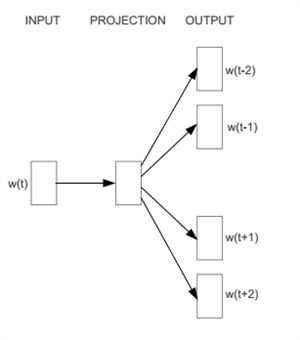

***前向传播***

首先计算所有词向量和当前词向量的‘得分’。然后利用softmax函数转换为概率形式。

对应的公式如下：
$$softmax(u_o^Tv_c) = p(o|c) = \hat y_o = \frac {e^{u_o^Tv_c}}{\sum _{w=1}^W e^{u_w^Tv_c}}$$

代码中的‘得分’就是公式中的中间变量$u_o^Tv_c$

***计算代价***

代价函数是交叉熵。

公式：$$J_t(\theta)= CE(y,\hat y) = -\sum_iy_ilog \hat y_i $$

***后向传播***

这里不是完整的后向传播，因为我们只计算了梯度，而没有进行随机梯度下降（SGD）。

关于随机梯度下降这里暂不考虑，专注于如何计算梯度，后续文章会专门介绍随机梯度下降的python实现。

根据word2vec的理念，我们需要通过随机梯度下降进行优化升级的是词向量，因此，需要计算两个梯度：$\frac {\partial J}{\partial v_c}$和$\frac {\partial J}{\partial U}$

同样这里直接给出公式，如果有读者好奇公式推导过程可以看这里：[自然语言处理（NLP）基础概念5：word2vec代价函数求梯度计算过程详解](https://zhuanlan.zhihu.com/p/29464327)

公式如下：
$$\frac {\partial J}{\partial v_c} = U(\hat y - y)$$
$$\frac {\partial J}{\partial U} = v_c(\hat y - y)^T$$


**严重注意！！！上面的公式是数学推导，但是实际代码中，出于效率的考虑，python中用行向量代表数学中的向量，所以实际部署中的公式与上述公式略有不同。**
技巧是，注意矩阵的维度！

## 3. 负采样和sigmoid计算代价和梯度

In [10]:
def negSamplingCostAndGradient(predicted, target, outputVectors, dataset,
                               K=10):
    """ Negative sampling cost function for word2vec models
    """
    indices = [target]
    indices.extend(getNegativeSamples(target, dataset, K))
    grad = np.zeros((outputVectors.shape[0],outputVectors.shape[1]))
    indices = indices[indices != target]

    # 1. forward propagation
    outvec = outputVectors[target].reshape(1,-1) #out vector
    negvec = outputVectors[indices].reshape(-1,outputVectors.shape[1]) #negative vectors
    y_score = np.dot(outvec,predicted.T)
    ns_score = np.dot(negvec,predicted.T)
    y_hat = sigmoid(y_score) # out vector prediction
    ns_hat = sigmoid(-ns_score) # negative sample prediction

    # 2. compute cost
    cost_o2c = -np.log(y_hat) # cost of out vector to center vector
    cost_n2c = -np.sum(np.log(ns_hat),0) # cost of negative vectors to center vector
    cost = cost_o2c + cost_n2c 
    
    # 3. backward propagation
    gradPred = (y_hat-1) * outvec - np.dot((ns_hat-1).T,negvec)
    grad[target] = (y_hat-1) * predicted
    grad[indices] = -np.dot((ns_hat-1),predicted)

    return cost, gradPred, grad

***输入参数***   
predicted是目标词向量。   
target是输出词向量（out vector）在输出词向量矩阵中的索引。   
outputVectors输出词向量矩阵。   
dataset用于负采样的参数。   
K=10负采样的数量。


***前向传播***   
注意采用负采样后的不同如下。   
相较于之前计算**全部**词向量与当前词向量的‘得分’，这里需要的‘得分’包括：
- 一个outvector与当前词向量的‘得分’: $u_o^Tv_c$
- 负采样的词向量与当前词向量的‘得分’: $-u_j^Tv_c$     

另外一个不同是，由于我们没有了**全部**词向量与当前词向量的‘得分’，因此无法使用softmax函数（softmax函数的分母是全部元素的和，这里没有**全部**元素），替换使用sigmoid函数（同样是将得分映射到概率）：
 $$sigmoid(x) = \sigma(x) = \frac{1}{1+e^{-x}}$$
值得注意的是，负采样的词向量与outvector不能重复，具体原因见下面的计算代价部分：

***计算代价***   
代价函数分为两部分：
- 当前词向量与outvector的代价
- 当前词向量与负采样词向量之间的代价   

公式：
$$J_t(\theta) =-log \sigma(u_o^Tv_c)-\sum_{k=1}^{K}log\sigma(-u_k^Tv_c)$$
注意，负采样的得分$-u_k^Tv_c$是负的，直观理解就是，我们希望目标词向量与相关输出词向量的代价值越小越好，反之，我们希望目标词向量与不相关的词向量之间的代价越大越好。因此，这是代价的两个方向，这也解释了为什么负采样的词向量与outvector不能重复。

***后向传播***   
想一想我们通过后向传播想要更新的目标是谁？目标有三个：
- 目标词向量$v_c$
- 输出词向量$u_o$
- 负采样词向量$u_k$   

公式如下：
$$\frac {\partial J}{\partial v_c} = (\sigma(u_o^Tv_c)-1)u_o-\sum _{k=1}^K(\sigma (-u_k^Tv_c)-1)u_k$$
$$\frac {\partial J}{\partial u_o} = (\sigma(u_o^Tv_c)-1)v_c$$
$$\frac {\partial J}{\partial u_k} = -(\sigma(-u_k^Tv_c)-1)v_c,\space for \space all \space k = 1,2,\dots,K$$   

最后，函数的输出包括：
cost： 代价值
gradPred：当前词向量的梯度
grad： 输出词向量的梯度（包括负采样词向量，因为来自同一个矩阵）

OK，负采样计算代价和梯度的函数写好，666！   
下面搭建skip-gram模型：

## 4.skip-gram模型

In [11]:
def skipgram(currentWord, C, contextWords, tokens, inputVectors, outputVectors,
             dataset, word2vecCostAndGradient=softmaxCostAndGradient):
    """ 
    Skip-gram model in word2vec
    """

    cost = 0.0
    gradIn = np.zeros(inputVectors.shape)
    gradOut = np.zeros(outputVectors.shape)

    idx = tokens[currentWord]
    predicted = inputVectors[idx].reshape(1,-1)

    for context in contextWords:
        target = tokens[context]
        if word2vecCostAndGradient == negSamplingCostAndGradient:
            cost, gradPred, grad = word2vecCostAndGradient(predicted, target, outputVectors, dataset, K=10)
        elif word2vecCostAndGradient == softmaxCostAndGradient:
            cost, gradPred, grad = softmaxCostAndGradient(predicted, target, outputVectors, dataset)

    gradIn[idx] = gradPred
    gradOut = grad

    return cost, gradIn, gradOut

***输入参数***   
- currrentWord：当前单词。   
- C：上下文大小。   
- contextWords：上下文单词，存储在list中，size是不大于2C。   
- tokens：用于将单词映射到词向量矩阵的索引，数据类型是词典。   
- inputVectors：输入词向量矩阵，由输入词向量（也就是上文说的当前词向量）组成的矩阵，矩阵的一行代表一个词向量。   
- outputVectors：输出词向量矩阵，矩阵的一行代表一个词向量。   
- word2vecCostAndGradient：函数，用于计算代价和梯度，输入参数控制使用哪种方式计算（可以选择用我们上面写过的两个函数：softmaxCostAndGradient和negSamplingCostAndGradient）   

***根据使用模型的不同，慎重选择输入参数***
这里，我们选择的模型是skip-gram：
![skip-gram model](https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1506664948168&di=bebf530100372979991fd8ef1a6f695e&imgtype=0&src=http%3A%2F%2F7te9qt.com1.z0.glb.clouddn.com%2F5.gif)
也就是说，我们计算的概率是已知输入是$v_c$的情况下，输出是$v_o$的概率：$p(v_o|v_c)$.    
因此，word2vecCostAndGradient()函数中的输入参数predicted是我们的当前词向量, target是输出词向量的索引。   
如果换成连续袋模型CBOW,我们想要的是已知输入是$v_o$的情况下，输出是$v_c$的概率: $p(v_c|v_o)$.    

### 5.随机梯度下降（sgd）

最后一步，实现随机梯度下降：

In [ ]:
def sgd(f, x0, step, iterations, postprocessing=None, useSaved=False,
        PRINT_EVERY=10):
    """ 
    Stochastic Gradient Descent
    """
    ANNEAL_EVERY = 20000
    start_iter = 0
    x = x0
    expcost = None

    for iter in xrange(start_iter + 1, iterations + 1):
        # Don't forget to apply the postprocessing after every iteration!
        # You might want to print the progress every few iterations.
        cost = None
        cost, grad = f(x)
        x = x - step * grad

        if iter % PRINT_EVERY == 0:
            if not expcost:
                expcost = cost
            else:
                expcost = .95 * expcost + .05 * cost
            print "iter %d: %f" % (iter, expcost)

        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x

***输入参数***
- f: 用于优化的函数，函数的输入一个参数x，输出x的两个参数：代价（cost）和梯度（gradient）
- x0: SGD的初始值
- step: SGD的步进，相当于神经网络的learning rate
- iterations: 总迭代次数
- postprocessing：后处理函数，这里暂时不用，保留用来以后增加处理权重的函数
- PRINT_EVERY -- 明确多少次迭代后输出代价值

***输出参数***
x: 优化后的权值。

1. 在每次迭代过程中，首先利用函数f(x)计算cost和gradient，这里的f可以是我们上面已经完成的函数skipgram()。
2. 随机梯度下降优化权重x = x - step * grad
3. 迭代一定次数后打印cost
4. 经过一定次数的迭代后降低step，因为随着梯度下降过程的进行，越接近最小值附近，越应该“步子迈的小一点”。

好了，大功告成！！！   
这篇文章专注于梳理搭建模型的思路，没有把包括测试在内的完整代码放到文章中。   
感兴趣的读者可以[打开我的github](https://github.com/freefrog1986/cs224n)下载assignment1。   
并依次在命令行运行：(注意最后的run.py可能需要运行很久！几十分钟~几个小时吧 ！)

In [ ]:
> python q3 word2vec.py
> python q3 sgd.py
> sh get datasets.sh
> python q3 run.py